# Machine Learning Project (Unsupervised Learning)

# Importing Libraries

In [1]:
# Importing all the necessary libraries.


from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import  OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import silhouette_score, make_scorer
import seaborn as sns

# Data Loading and Preprocessing

In [2]:
# Source :
# https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification

data = pd.read_csv('liver_cirrhosis.csv')

In [3]:
data.shape

(25000, 18)

In [4]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5


In [5]:
# Converting the age attribute from Days into Years.

data['Age'] = data['Age']/365
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,2221,C,Placebo,50.682192,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9
1,1230,C,Placebo,54.038356,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8
2,4184,C,Placebo,32.435616,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0
3,2090,D,Placebo,45.115068,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2
4,2105,D,Placebo,59.449315,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5


# Exploratory Data Analysis (EDA)

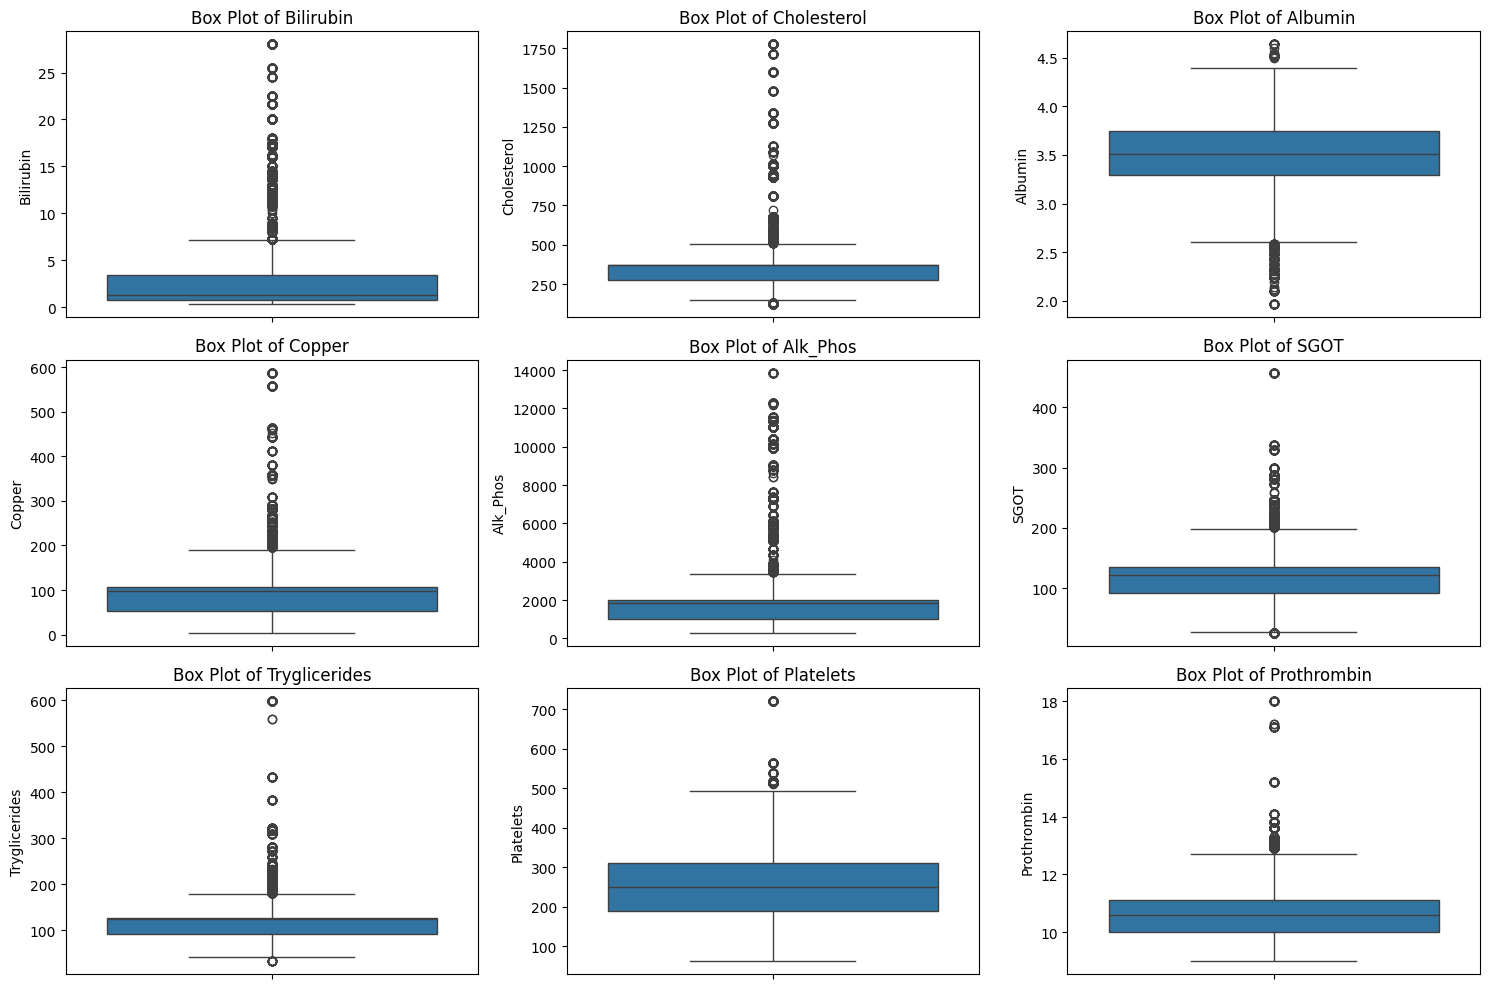

In [6]:
# Plotting the Box Plots for the features mentioned below to check for Outliers.


features = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=data[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [7]:
# Removing Outliers based on the Box Plots obtained above.


numerical_cols = data.select_dtypes(include=['number']).columns

Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_filtered = data[~((data[numerical_cols] < lower_bound) | (data[numerical_cols] > upper_bound)).any(axis=1)]

print("Original shape:", data.shape)
print("Filtered shape:", data_filtered.shape)
data = data_filtered

Original shape: (25000, 18)
Filtered shape: (15361, 18)


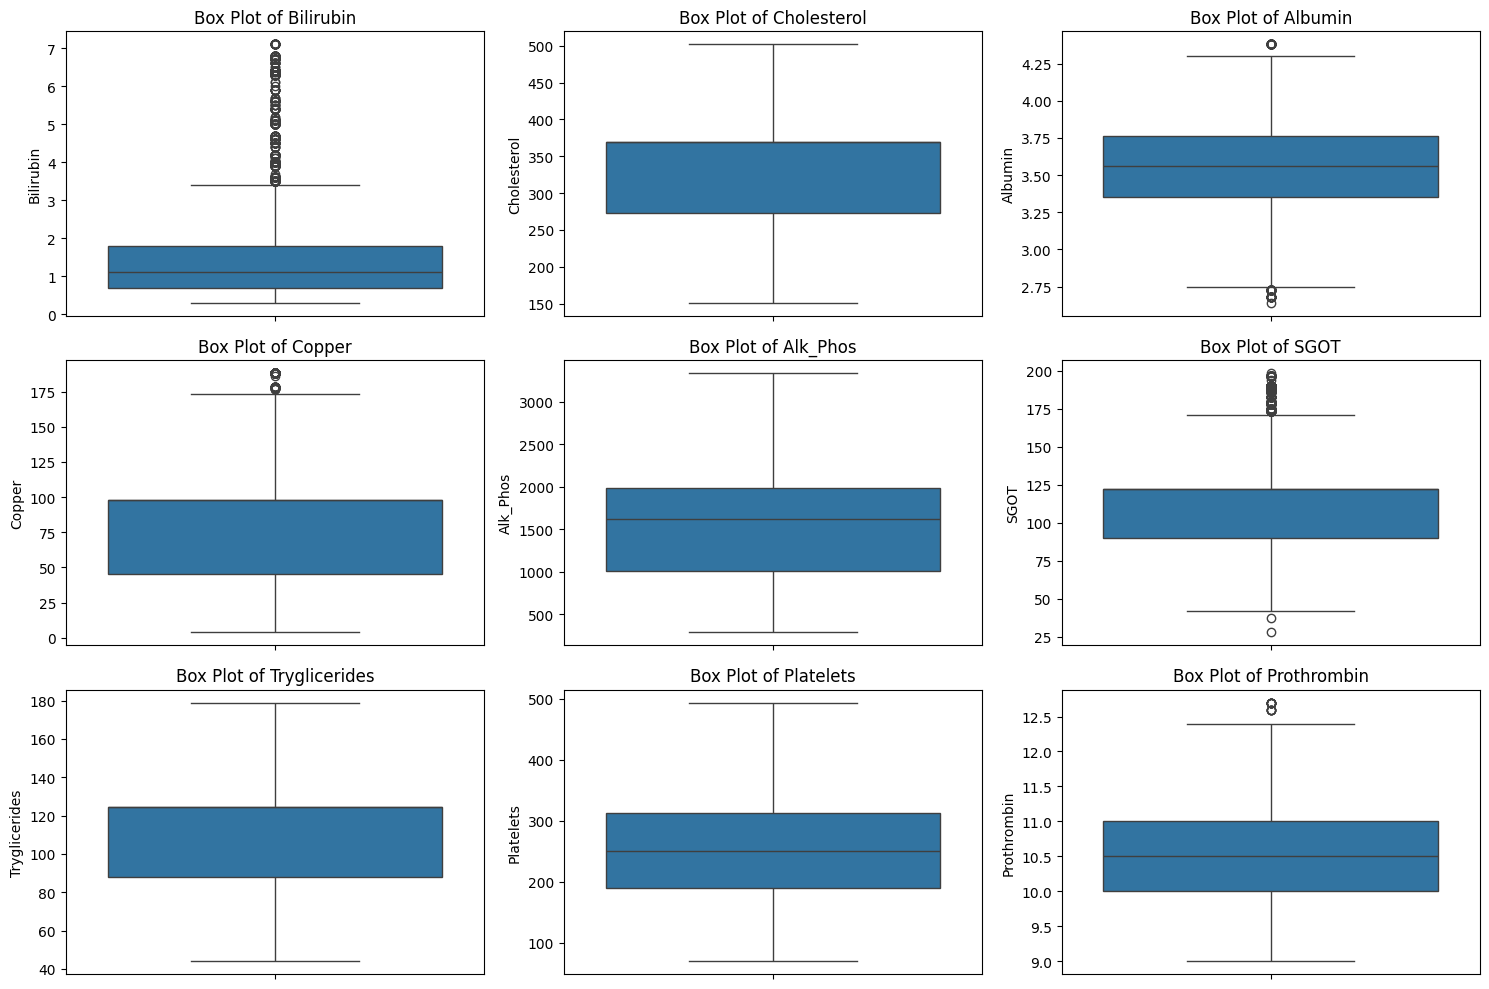

In [8]:
# Box Plots obtained after removing outliers.

features = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=data[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

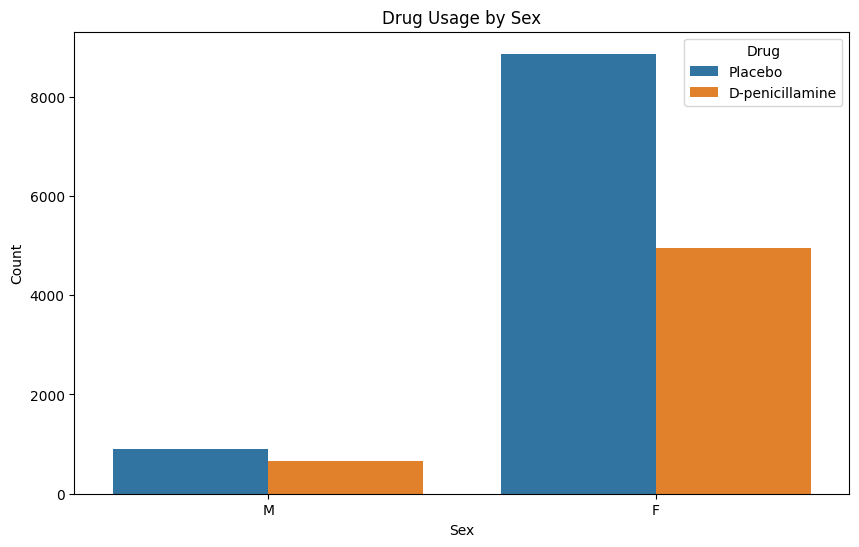

In [9]:
# Double Bar Chart for Drug Usage by Sex(M/F).

plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Drug', data=data)
plt.title('Drug Usage by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

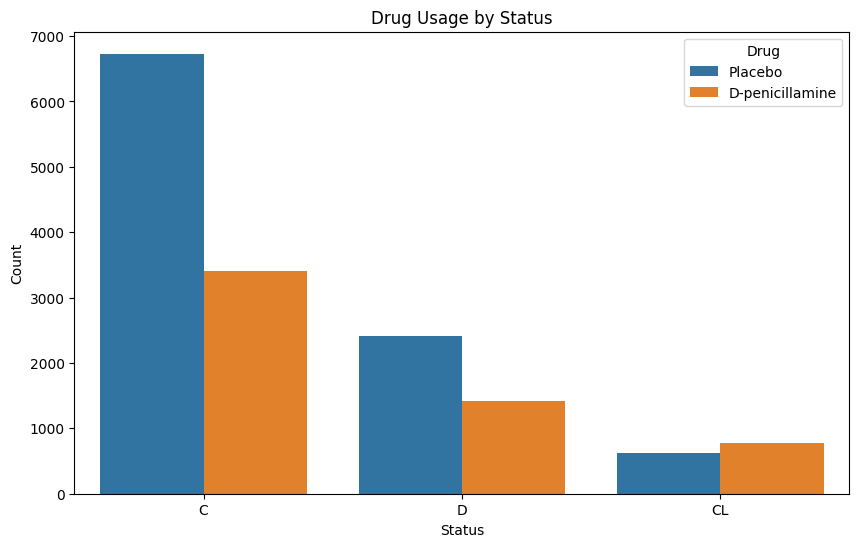

In [10]:
# Double Bar Chart for Drug usage by status of the patient.

plt.figure(figsize=(10, 6))
sns.countplot(x='Status', hue='Drug', data=data)
plt.title('Drug Usage by Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

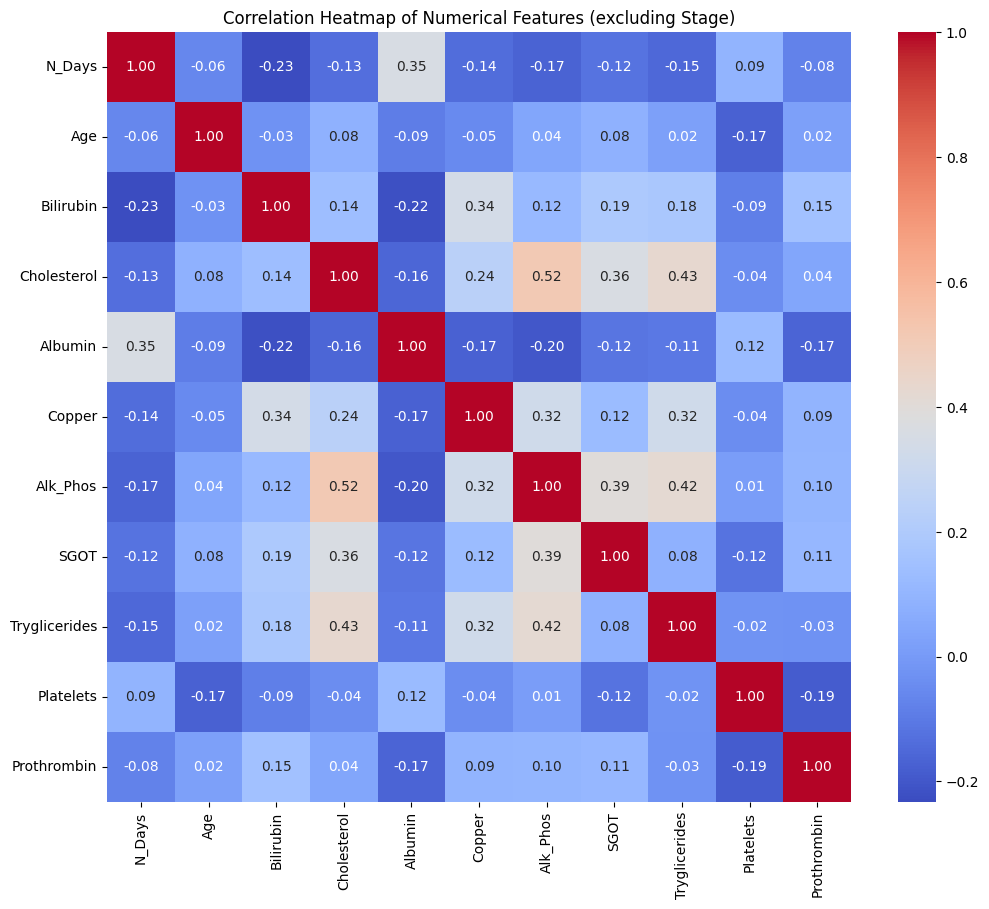

In [11]:
# Heatmap of all the numerical variables to check if there is Correlation between any of them.


numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 10))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features (excluding Stage)')
plt.show()

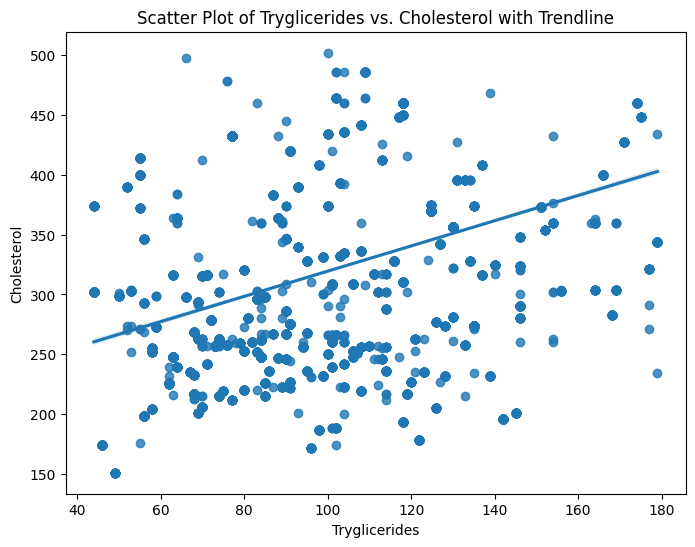

In [12]:
# Scatter Plot of Tryglicerides vs. Cholesterol with Trendline.

plt.figure(figsize=(8, 6))
sns.regplot(x='Tryglicerides', y='Cholesterol', data=data)
plt.title('Scatter Plot of Tryglicerides vs. Cholesterol with Trendline')
plt.xlabel('Tryglicerides')
plt.ylabel('Cholesterol')
plt.show()

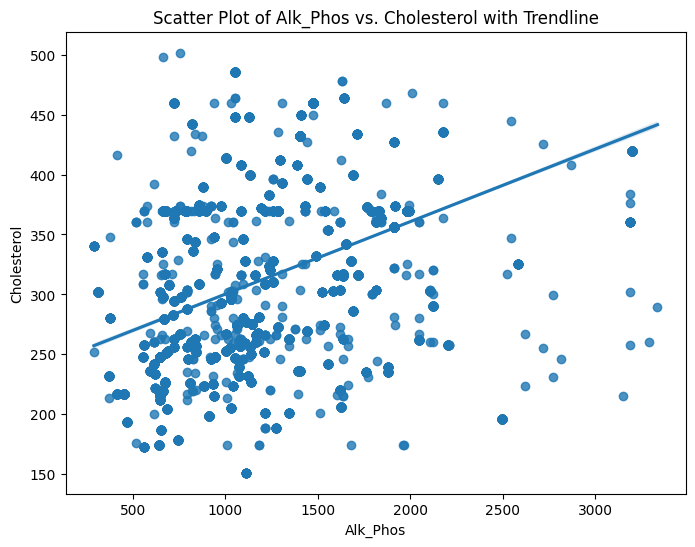

In [13]:
# Scatter Plot of Alk_Phos vs. Cholesterol with Trendline.

plt.figure(figsize=(8, 6))
sns.regplot(x='Alk_Phos', y='Cholesterol', data=data)
plt.title('Scatter Plot of Alk_Phos vs. Cholesterol with Trendline')
plt.xlabel('Alk_Phos')
plt.ylabel('Cholesterol')
plt.show()

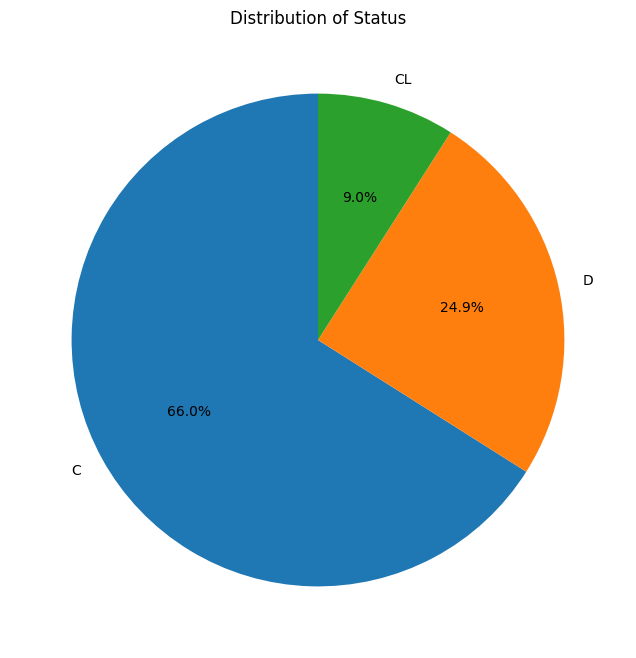

In [14]:
# Pie Chart for Distribution of Status.

status_counts = data['Status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Status')
plt.show()

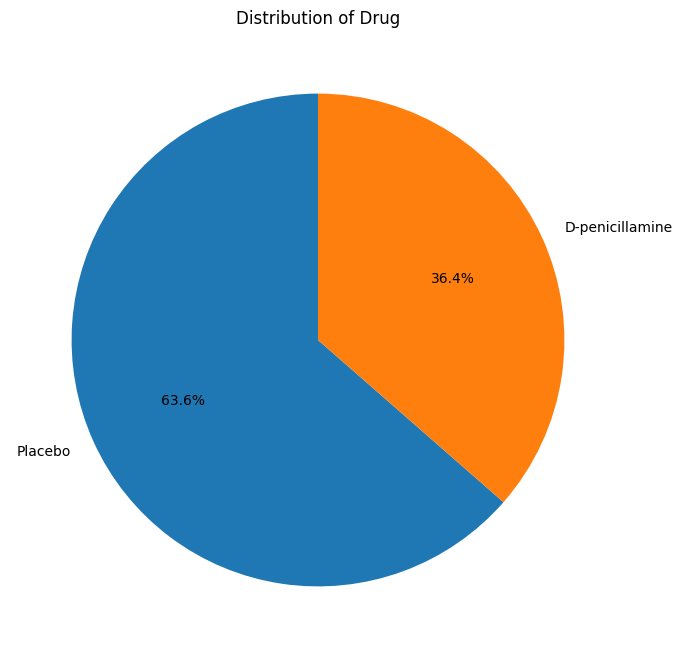

In [15]:
# Pie Chart for Distribution of Drug.

drug_counts = data['Drug'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(drug_counts, labels=drug_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Drug')
plt.show()

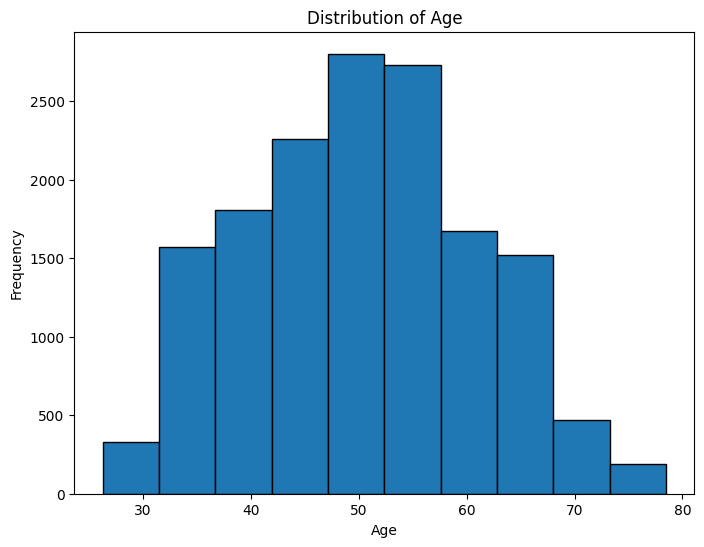

In [16]:
# Distribution of Age of Patients.

plt.figure(figsize=(8, 6))
plt.hist(data['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

# Model-1: KMeans

1. Define feature groups:
   - Categorical features: ['Hepatomegaly', 'Spiders', 'Edema']
   - Numerical features: ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

2. Extract required columns from the dataset:
   - `data = data[numerical_features + categorical_features]`

3. Define transformers for preprocessing:
   - Numeric transformer: MinMaxScaler()
   - Categorical transformer: OneHotEncoder()

4. Create a column transformer:
   - `preprocessor = ColumnTransformer` with:
     - 'num': Apply `numeric_transformer` to `numerical_features`.
     - 'cat': Apply `categorical_transformer` to `categorical_features`.

5. Preprocess the data:
   - `data_scaled = preprocessor.fit_transform(data)`

6. Initialize variables for KMeans:
   - `inertia_values = []`
   - `cluster_range = range(1, 11)` (Cluster numbers to evaluate)

7. Perform KMeans clustering for different cluster counts:
   - For each `k` in `cluster_range`:
     - Initialize `KMeans` with `n_clusters=k`.
     - Fit `KMeans` to `data_scaled`.
     - Append `kmeans.inertia_` to `inertia_values`.

8. Plot the Elbow Curve:
   - Plot `inertia_values` against `cluster_range`.
   - Add labels, title, and grid to the plot.

9. Choose the number of clusters (`k=4`) based on the elbow method:
   - Initialize `KMeans` with `n_clusters=4`.
   - Fit `KMeans` to `data_scaled`.
   - Assign cluster labels to the data: `data['Cluster'] = labels`.

10. Calculate the Silhouette Score:
    - Compute `silhouette_score(data_scaled, labels)`.

11. Perform PCA for dimensionality reduction:
    - Initialize `PCA` with `n_components=5`.
    - Transform `data_scaled` using PCA.

12. Visualize the clusters:
    - Create a scatter plot of the first two PCA components:
      - Use cluster labels as the color.
      - Add a colorbar, title, and axis labels.

13. Display the silhouette score on the plot title.


In [17]:
# Processing the categorical as well as numerical features in our data.

categorical_features = [ 'Hepatomegaly', 'Spiders', 'Edema']
numerical_features = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

data = data[numerical_features + categorical_features]

numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

data_scaled = preprocessor.fit_transform(data)

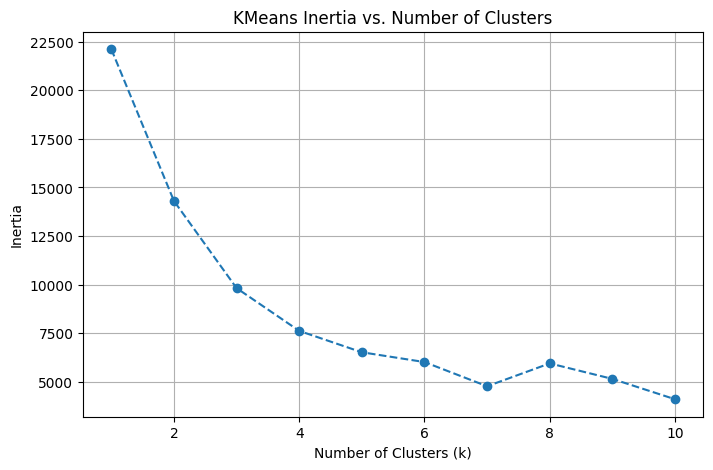

In [18]:
# Plotting Inertia for different values of K to find the optimal value using Elbow method.

inertia_values = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k,init="k-means++", random_state=2024)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.title('KMeans Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [19]:
# Training KMeans Model on our data and calculating the Silhouette score.

kmeans = KMeans(n_clusters = 4, random_state = 2024,init = 'k-means++')
labels = kmeans.fit_predict(data_scaled)
data['Cluster'] = labels

silhouette = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {silhouette}")

/var/folders/_y/z_ggxb911fqfnxb7012b8_pc0000gn/T/ipykernel_21761/1530459217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = labels


Silhouette Score: 0.4888407808052515


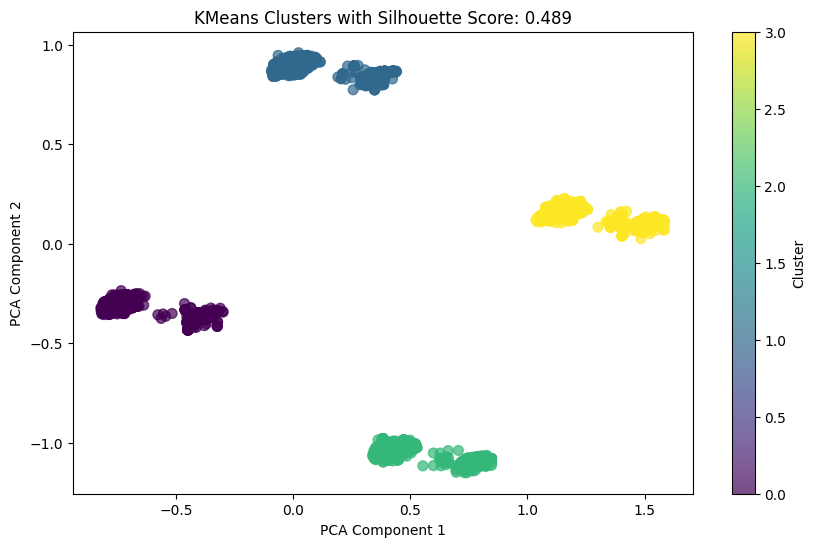

In [20]:
# Visualising the clusters made by KMeans Model.

pca = PCA(n_components = 5)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_pca[:, 1], data_pca[:, 0] ,c = labels, cmap='viridis', s = 50, alpha = 0.7)
plt.title(f'KMeans Clusters with Silhouette Score: {silhouette:.3f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label = 'Cluster')
plt.show()

# Model-2: DBSCAN

1. Create a pipeline:
   - Preprocessing:
     - Use `preprocessor` (scaling and encoding).
   - Clustering:
     - Apply `DBSCAN`.

2. Define parameter grid for hyperparameter tuning:
   - `dbscan__eps`: [0.9, 1.0, 1.1, ..., 1.4]
   - `dbscan__min_samples`: [5, 10, 15]
   - `dbscan__metric`: ['euclidean', 'manhattan']

3. Define a custom scoring function:
   - If the number of unique cluster labels > 1:
     - Return silhouette score for the labels.
   - Else:
     - Return -1 (indicates poor clustering).

4. Create a custom scorer using `make_scorer`.

5. Use `RandomizedSearchCV` to find the best DBSCAN parameters:
   - Pass the pipeline, parameter grid, scoring function, and number of iterations (20).
   - Use 5-fold cross-validation.
   - Run the search using all available processors (`n_jobs=-1`).

6. Fit the random search object to the dataset.
7. Extract the best parameters and the corresponding DBSCAN estimator.
8. Get cluster labels from the best DBSCAN model.
9. Compute the silhouette score for the resulting clusters.
10. Identify unique cluster labels (excluding noise `-1`).
11. Compute cluster centroids:
    - For each cluster (excluding noise):
      - Compute the mean of the scaled data points belonging to the cluster.

12. Compute the pairwise distances between centroids.

13. Set a distance threshold for merging (e.g., 2.0).
14. Initialize `merged_labels` as a copy of the DBSCAN labels.

15. For each pair of clusters:
    - If the distance between their centroids is less than the threshold:
      - Merge the clusters by reassigning their labels.

16. Compute the silhouette score for the merged clusters.
17. Identify the unique merged cluster labels.
18. Plot the clusters using PCA-reduced data:
    - Use the first two PCA components.
    - Color points based on the merged cluster labels.
    - Add a colorbar, title, and axis labels.



In [21]:
dbscan_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dbscan', DBSCAN())
])

param_dist = {
    'dbscan__eps': [i / 10 for i in range(9, 15)],
    'dbscan__min_samples': [5, 10, 15],
    'dbscan__metric': ['euclidean', 'manhattan']
}

def silhouette_scorer(estimator, X):
    labels = estimator['dbscan'].labels_
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    return -1

silhouette_scorer_custom = make_scorer(silhouette_scorer, greater_is_better=True)
random_search = RandomizedSearchCV(dbscan_pipeline, n_iter = 20,  param_distributions = param_dist, cv = 5, scoring = silhouette_scorer_custom, n_jobs=-1)
random_search.fit(data)

print("Best Parameters:", random_search.best_params_)

/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _s

Best Parameters: {'dbscan__min_samples': 10, 'dbscan__metric': 'manhattan', 'dbscan__eps': 1.0}


In [22]:
best_dbscan = random_search.best_estimator_
best_dbscan_labels = best_dbscan['dbscan'].labels_
sil_score = silhouette_score(data_scaled, best_dbscan_labels)
print("Silhouette Score with Best Parameters:", sil_score)
np.unique(best_dbscan_labels)

Silhouette Score with Best Parameters: 0.582886287566816


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
unique_labels = np.unique(best_dbscan_labels)
unique_labels = unique_labels[unique_labels != -1]

centroids = []
for cluster in unique_labels:
    centroids.append(data_scaled[best_dbscan_labels == cluster].mean(axis=0))
centroids = np.array(centroids)

distances = cdist(centroids, centroids)

threshold = 2

merged_labels = best_dbscan_labels.copy()  
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        if distances[i, j] < threshold:
            merged_labels[merged_labels == unique_labels[j]] = unique_labels[i]

np.unique(merged_labels)
sil_score1 = silhouette_score(data_scaled, merged_labels)
print("Silhouette Score with Best Parameters:", sil_score1)

Silhouette Score with Best Parameters: 0.27256081160345497


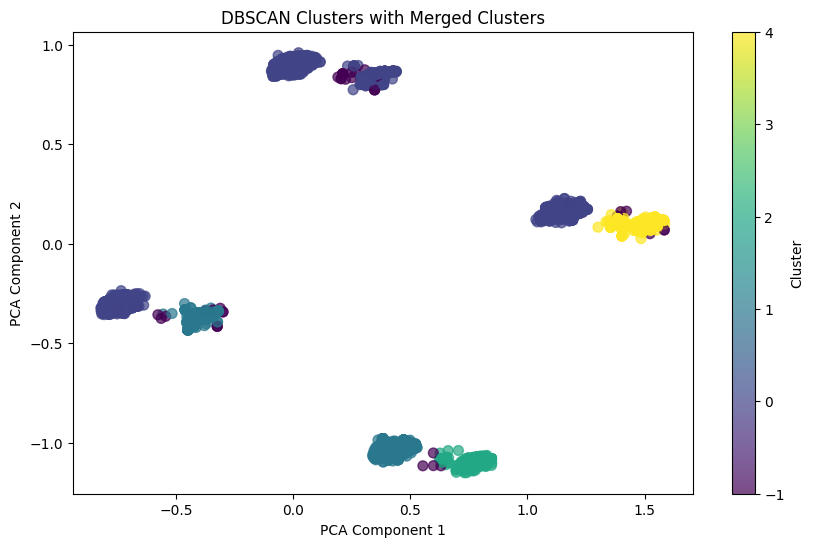

In [24]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_pca[:, 1], data_pca[:,0], c=merged_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clusters with Merged Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Model-3: Gaussian Mixture

1. Define a pipeline:
   - Preprocessor: Combines MinMaxScaler and OneHotEncoder.
   - GMM: Gaussian Mixture Model.

2. Define hyperparameter grid:
   - 'gmm__n_components': Range from 5 to 10.
   - 'gmm__covariance_type': ['spherical', 'tied', 'diag'].

3. Create a custom scoring function:
   - Calculate silhouette score for GMM-predicted labels.

4. Perform randomized search:
   - Use RandomizedSearchCV with:
     - Pipeline as the estimator.
     - Hyperparameter grid.
     - 5-fold cross-validation.
     - 25 iterations.
     - Custom silhouette scorer.
   - Fit the search to the dataset.

5. Extract the best model and hyperparameters:
   - `best_gmm = random_search.best_estimator_`.
   - `best_gmm_labels = best_gmm['gmm'].predict(transformed_data)`.

6. Compute the silhouette score for the best model:
   - `silhouette_score(transformed_data, best_gmm_labels)`.

7. Visualize the clusters:
   - Use PCA-reduced data (first and fourth principal components).
   - Scatter plot with cluster labels as colors.
   - Add titles, labels, and a color bar.

8. Display the silhouette score on the visualization.


In [25]:
# Performing Random Search to get the best hyperparameters for Gaussian Mixture Model.

gmm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gmm', GaussianMixture())
])

param_distributions = {
    'gmm__n_components': [5,6,7,8,9,10],
    'gmm__covariance_type': ['spherical','tied', 'diag']
}


def silhouette_scorer(estimator, X):
    labels = estimator['gmm'].predict(X)
    
    return silhouette_score(X, labels)

silhouette_scorer_custom = make_scorer(silhouette_scorer, greater_is_better=True)

random_search = RandomizedSearchCV(
    gmm_pipeline,
    param_distributions,
    cv = 5,
    scoring = silhouette_scorer_custom,
    n_jobs = -1,
    n_iter = 25,
    random_state = 2024
)
random_search.fit(data)

print("Best Parameters:", random_search.best_params_)

/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=25. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring f

Best Parameters: {'gmm__n_components': 5, 'gmm__covariance_type': 'spherical'}


/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dhruv/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _s

In [26]:
# Training Gaussian Mixture model based on best hyperparameters.

best_gmm = random_search.best_estimator_

data_transformed = preprocessor.fit_transform(data)
best_gmm_labels = best_gmm['gmm'].predict(data_transformed)
sil_score = silhouette_score(data_transformed, best_gmm_labels)
print("Silhouette Score with Best Parameters:", sil_score)

Silhouette Score with Best Parameters: 0.5041317461990313


/var/folders/_y/z_ggxb911fqfnxb7012b8_pc0000gn/T/ipykernel_21761/1543835729.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


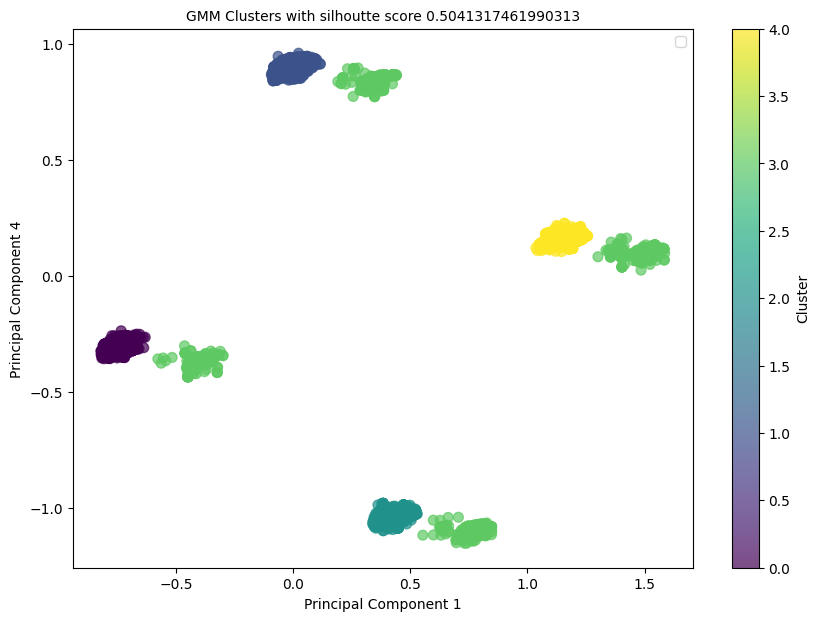

In [27]:
# Visualise the Clusters Made by Gaussian Mixture Model.

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data_pca[:, 1], data_pca[:,0], c=best_gmm_labels, cmap='viridis', s=50, alpha=0.7)

plt.title(f'GMM Clusters with silhoutte score {sil_score}', fontsize = 10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 4')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()